# Exercise Solution: Fine-Tune and Evaluate a Q&A Model

## Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator
)
import warnings
warnings.filterwarnings('ignore')

from exercise_utils import (
    create_squad_subset,
    prepare_train_features,
    prepare_validation_features,
    postprocess_qa_predictions,
    compute_exact_match,
    compute_f1_score,
    plot_metrics_comparison,
    plot_learning_rate_comparison,
    print_metrics_summary
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("✅ Setup complete!")
print(f"PyTorch: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✅ Setup complete!
PyTorch: 2.9.1
Device: CPU


---
# Fine-Tune DistilBERT for Q&A

## Step A.1: Load SQuAD 2.0 Dataset

In [2]:
print("📥 Loading SQuAD 2.0...")
dataset = load_dataset("squad_v2")

print("\n🔄 Creating subsets...")
train_dataset = create_squad_subset(dataset['train'], n_samples=1000, seed=SEED)
test_dataset = create_squad_subset(dataset['validation'], n_samples=200, seed=SEED)

print(f"\n✅ Ready: {len(train_dataset)} train, {len(test_dataset)} test")

example = train_dataset[0]
print(f"\nExample Q: {example['question']}")
print(f"Answer: {example['answers']['text'][0]}")

📥 Loading SQuAD 2.0...

🔄 Creating subsets...


Filter:   0%|          | 0/130319 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11873 [00:00<?, ? examples/s]


✅ Ready: 1000 train, 200 test

Example Q: After cellulose, what component is most plentiful in wood?
Answer: hemicellulose


## Load Pretrained DistilBERT

In [3]:
MODEL_NAME = "distilbert-base-uncased"

print("📥 Loading model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

print(f"\n✅ Loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📥 Loading model...

✅ Loaded: 66,364,418 parameters


## Tokenize Dataset

In [4]:
print("🔧 Tokenizing...")

tokenized_train = train_dataset.map(
    lambda x: prepare_train_features(x, tokenizer),
    batched=True,
    remove_columns=train_dataset.column_names,
)

tokenized_test = test_dataset.map(
    lambda x: prepare_validation_features(x, tokenizer),
    batched=True,
    remove_columns=test_dataset.column_names,
)

print(f"✅ Done: {len(tokenized_train)} train, {len(tokenized_test)} test samples")

# Verify tokenization worked correctly
print("\n🔍 Verifying tokenized data...")
sample = tokenized_train[0]
print(f"   Keys: {list(sample.keys())}")
print(f"   Input IDs length: {len(sample['input_ids'])}")
print(f"   Start position: {sample['start_positions']}")
print(f"   End position: {sample['end_positions']}")

# Check if we have valid answer positions
valid_answers = sum(1 for s in tokenized_train if s['start_positions'] > 0)
print(f"   Samples with valid answers: {valid_answers}/{len(tokenized_train)}")

if valid_answers == 0:
    print("\n⚠️ WARNING: No valid answer positions found!")
    print("   This will cause training loss to be 0.")
    print("   Checking first example in detail...")
    
    # Debug first example
    orig_ex = train_dataset[0]
    print(f"\n   Original question: {orig_ex['question']}")
    print(f"   Original answer: {orig_ex['answers']['text'][0]}")
    print(f"   Answer start char: {orig_ex['answers']['answer_start'][0]}")
    print(f"   Context snippet: ...{orig_ex['context'][orig_ex['answers']['answer_start'][0]:orig_ex['answers']['answer_start'][0]+50]}...")
    
    # Check tokenized version
    tok_ex = tokenized_train[0]
    decoded = tokenizer.decode(tok_ex['input_ids'])
    print(f"\n   Decoded tokens: {decoded[:200]}...")
else:
    print(f"\n✅ Good! {valid_answers} samples have valid answer positions.")
    
    # Show example of valid answer
    for idx, s in enumerate(tokenized_train):
        if s['start_positions'] > 0:
            print(f"\n   Example valid answer (sample {idx}):")
            answer_tokens = tokenizer.decode(s['input_ids'][s['start_positions']:s['end_positions']+1])
            print(f"   Answer tokens: '{answer_tokens}'")
            orig = train_dataset[idx]
            print(f"   Ground truth: '{orig['answers']['text'][0]}'")
            break

🔧 Tokenizing...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

✅ Done: 1015 train, 201 test samples

🔍 Verifying tokenized data...
   Keys: ['input_ids', 'attention_mask', 'start_positions', 'end_positions']
   Input IDs length: 384
   Start position: 49
   End position: 53
   Samples with valid answers: 1003/1015

✅ Good! 1003 samples have valid answer positions.

   Example valid answer (sample 0):
   Answer tokens: 'hemicellulose'
   Ground truth: 'hemicellulose'


## Configure Training

In [6]:
# Calculate total steps for proper logging
total_steps = len(tokenized_train) // 16 * 3  # dataset_size / batch_size * epochs
logging_steps = max(10, total_steps // 20)  # Log ~20 times during training

training_args = TrainingArguments(
    output_dir="./finetuned-distilbert-qa",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=logging_steps,
    logging_first_step=True,
    seed=SEED,
    # load_best_model_at_end=True,
    # metric_for_best_model="loss",
    save_total_limit=2,  # Only keep 2 checkpoints
    report_to="none",  # Don't use external logging
)

print(f"⚙️ LR={training_args.learning_rate}, Batch={training_args.per_device_train_batch_size}, Epochs={int(training_args.num_train_epochs)}")
print(f"   Total steps: {total_steps}, Logging every {logging_steps} steps")

⚙️ LR=2e-05, Batch=16, Epochs=3
   Total steps: 189, Logging every 10 steps


## Initialize Trainer

In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

print("✅ Trainer ready!")

✅ Trainer ready!


## Fine-Tune

In [8]:
print("🚀 Fine-tuning...\n")
train_result = trainer.train()
print(f"\n✅ Done in {train_result.metrics['train_runtime']:.1f}s")
print(f"   Final loss: {train_result.metrics.get('train_loss', 'N/A')}")
print(f"   Steps completed: {train_result.metrics.get('train_steps_per_second', 0) * train_result.metrics['train_runtime']:.0f}")

🚀 Fine-tuning...



Epoch,Training Loss,Validation Loss
1,4.195200,No log
2,3.897500,No log
3,3.520700,No log



✅ Done in 213.1s
   Final loss: 4.043804268042247
   Steps completed: 192


### Check Training Results


🔍 Training Metrics:
   train_runtime: 213.1224
   train_samples_per_second: 14.288
   train_steps_per_second: 0.901
   total_flos: 298379017198080.0
   train_loss: 4.043804268042247
   epoch: 3.0

📊 Log history entries: 24

First log entry:
{'loss': 6.0181, 'grad_norm': 3.457120180130005, 'learning_rate': 2e-05, 'epoch': 0.015625, 'step': 1}

Last log entry:
{'train_runtime': 213.1224, 'train_samples_per_second': 14.288, 'train_steps_per_second': 0.901, 'total_flos': 298379017198080.0, 'train_loss': 4.043804268042247, 'epoch': 3.0, 'step': 192}

   Training loss entries: 20
   Eval loss entries: 0

📉 Sample training losses:
   Step 1: Loss 6.0181
   Step 10: Loss 5.8244
   Step 20: Loss 5.4584


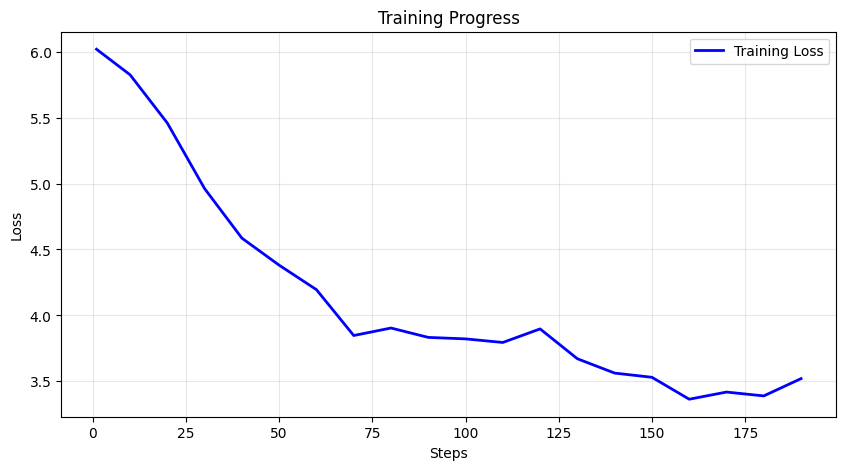

In [9]:
# Debug: Check what's in the training result
print("\n🔍 Training Metrics:")
for key, value in train_result.metrics.items():
    print(f"   {key}: {value}")

# Check training history
if hasattr(trainer.state, 'log_history'):
    print(f"\n📊 Log history entries: {len(trainer.state.log_history)}")
    
    # Show first few and last few entries
    if trainer.state.log_history:
        print("\nFirst log entry:")
        print(trainer.state.log_history[0])
        print("\nLast log entry:")
        print(trainer.state.log_history[-1])
        
        # Try to plot
        train_losses = [h for h in trainer.state.log_history if 'loss' in h]
        eval_losses = [h for h in trainer.state.log_history if 'eval_loss' in h]
        
        print(f"\n   Training loss entries: {len(train_losses)}")
        print(f"   Eval loss entries: {len(eval_losses)}")
        
        if train_losses:
            print("\n📉 Sample training losses:")
            for entry in train_losses[:3]:
                print(f"   Step {entry.get('step', '?')}: Loss {entry.get('loss', 0):.4f}")
        
        # Plot if we have real data
        if train_losses and any(h.get('loss', 0) > 0 for h in train_losses):
            fig, ax = plt.subplots(figsize=(10, 5))
            
            steps = [h['step'] for h in train_losses if 'step' in h]
            losses = [h['loss'] for h in train_losses if 'loss' in h]
            
            if steps and losses:
                ax.plot(steps, losses, 'b-', label='Training Loss', linewidth=2)
                ax.set_xlabel('Steps')
                ax.set_ylabel('Loss')
                ax.set_title('Training Progress')
                ax.legend()
                ax.grid(True, alpha=0.3)
                plt.show()
        else:
            print("\n⚠️ No valid training loss values found (all zeros or missing)")
            print("   This suggests the model may not have trained properly.")
            print("   Common causes:")
            print("   - Dataset formatting issues")
            print("   - All labels set to -100 (ignored)")
            print("   - Model architecture mismatch")

## Step A.7: Save Model

In [11]:
output_dir = "./finetuned-distilbert-qa"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"✅ Saved to {output_dir}/")

✅ Saved to ./finetuned-distilbert-qa/


---
# Comprehensive Evaluation

## Evaluate Baseline

In [12]:
print("🔍 Baseline evaluation...")

baseline_model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
baseline_trainer = Trainer(model=baseline_model, tokenizer=tokenizer)

baseline_preds = baseline_trainer.predict(tokenized_test)
baseline_answers = postprocess_qa_predictions(
    test_dataset, tokenized_test,
    (baseline_preds.predictions[0], baseline_preds.predictions[1])
)

references = {ex['id']: ex['answers']['text'] for ex in test_dataset}

baseline_em = compute_exact_match(baseline_answers, references)
baseline_f1 = compute_f1_score(baseline_answers, references)

print(f"\nBaseline: EM={baseline_em:.1f}%, F1={baseline_f1:.1f}%")

🔍 Baseline evaluation...


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Baseline: EM=0.0%, F1=8.3%


## Evaluate Fine-Tuned

In [13]:
print("🔍 Fine-tuned evaluation...")

finetuned_preds = trainer.predict(tokenized_test)
finetuned_answers = postprocess_qa_predictions(
    test_dataset, tokenized_test,
    (finetuned_preds.predictions[0], finetuned_preds.predictions[1])
)

finetuned_em = compute_exact_match(finetuned_answers, references)
finetuned_f1 = compute_f1_score(finetuned_answers, references)

print(f"\nFine-tuned: EM={finetuned_em:.1f}%, F1={finetuned_f1:.1f}%")

🔍 Fine-tuned evaluation...



Fine-tuned: EM=4.5%, F1=10.7%


## Metrics Table

In [14]:
baseline_metrics = {'EM': baseline_em, 'F1': baseline_f1}
finetuned_metrics = {'EM': finetuned_em, 'F1': finetuned_f1}

print_metrics_summary(baseline_metrics, finetuned_metrics)

df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Fine-Tuned': finetuned_metrics
}).T
df['EM Δ'] = df['EM'] - baseline_em
df['F1 Δ'] = df['F1'] - baseline_f1

display(df)


METRICS SUMMARY: Baseline vs. Fine-Tuned

📊 Baseline Model (Pretrained, No Fine-Tuning):
   • Exact Match (EM): 0.0%
   • F1 Score:         8.3%

🎯 Fine-Tuned Model:
   • Exact Match (EM): 4.5%
   • F1 Score:         10.7%

📈 Improvement:
   • EM improved by:   +4.5 percentage points
   • F1 improved by:   +2.4 percentage points

💡 Key Insight:
   Fine-tuning improved F1 by 2.4 percentage points!
   This demonstrates the power of transfer learning with limited data.



,EM,F1,EM Δ,F1 Δ
Baseline,0.0,8.304073,0.0,0.000000
Fine-Tuned,4.5,10.725812,4.5,2.421739


## B.5: Visualization

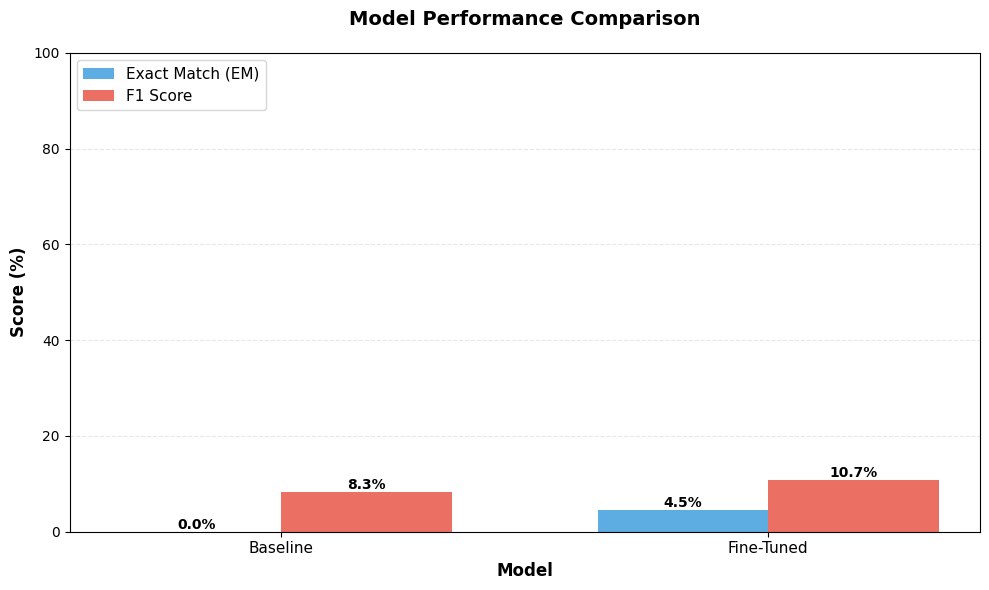


💡 F1 improved by 2.4 points!


In [15]:
plot_metrics_comparison(
    {'Baseline': baseline_metrics, 'Fine-Tuned': finetuned_metrics}
)
plt.show()

print(f"\n💡 F1 improved by {finetuned_f1 - baseline_f1:.1f} points!")

---
# Learning Rate Experiment

## Train with Higher LR

In [ ]:
print("🔬 Training with higher LR...\n")

model_high_lr = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

# Calculate logging steps
total_steps_high = len(tokenized_train) // 16 * 2
logging_steps_high = max(10, total_steps_high // 15)

training_args_high = TrainingArguments(
    output_dir="./finetuned-high-lr",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=logging_steps_high,
    logging_first_step=True,
    seed=SEED,
    report_to="none",
)

trainer_high = Trainer(
    model=model_high_lr,
    args=training_args_high,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

train_result_high = trainer_high.train()
print(f"\n✅ Done in {train_result_high.metrics['train_runtime']:.1f}s")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔬 Training with LR=5e-5...



Epoch,Training Loss,Validation Loss
1,3.769800,No log
2,3.425200,No log



✅ Done in 164.6s


## Evaluate High LR Model

In [19]:
preds_high = trainer_high.predict(tokenized_test)
answers_high = postprocess_qa_predictions(
    test_dataset, tokenized_test,
    (preds_high.predictions[0], preds_high.predictions[1])
)

em_high = compute_exact_match(answers_high, references)
f1_high = compute_f1_score(answers_high, references)

print(f"High LR: EM={em_high:.1f}%, F1={f1_high:.1f}%")

High LR: EM=10.0%, F1=16.2%


## Comparison Table

In [20]:
comparison = pd.DataFrame({
    'LR': ['2e-5', '5e-5'],
    'Epochs': [3, 2],
    'F1 (%)': [finetuned_f1, f1_high],
    'EM (%)': [finetuned_em, em_high],
    'Time (s)': [
        train_result.metrics['train_runtime'],
        train_result_high.metrics['train_runtime']
    ]
})

display(comparison)

winner = '2e-5' if finetuned_f1 > f1_high else '5e-5'
print(f"\n🏆 Winner: LR={winner}")

,LR,Epochs,F1 (%),EM (%),Time (s)
0,2e-5,3,10.725812,4.5,213.1224
1,5e-5,2,16.188238,10.0,164.5976



🏆 Winner: LR=5e-5


## Visualization

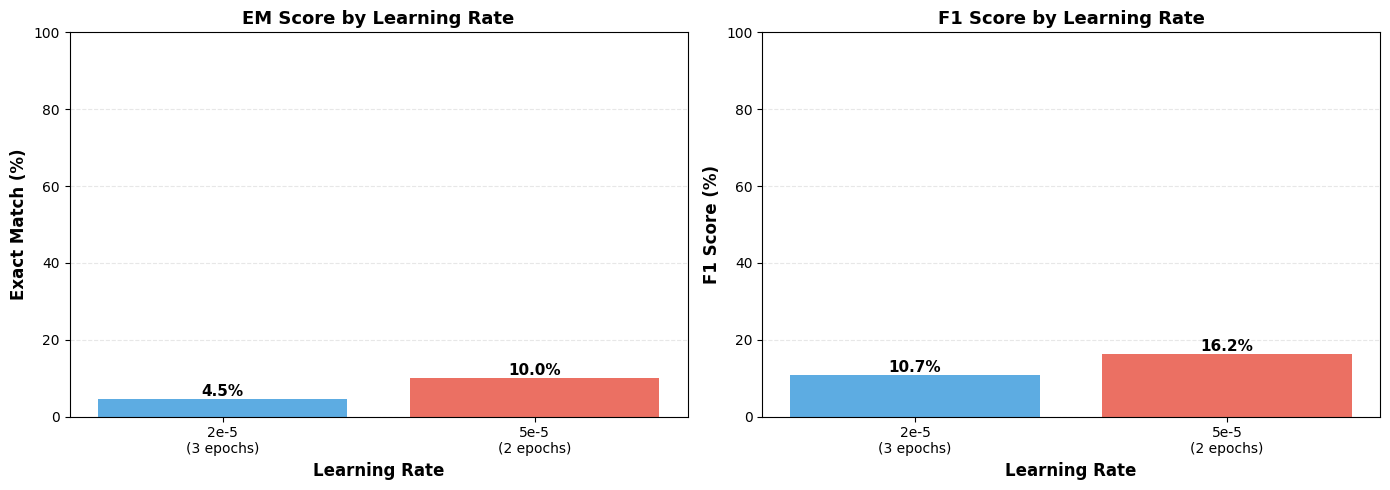

In [21]:
plot_learning_rate_comparison([
    {'lr': '2e-5', 'epochs': 3, 'em': finetuned_em, 'f1': finetuned_f1},
    {'lr': '5e-5', 'epochs': 2, 'em': em_high, 'f1': f1_high}
])
plt.show()

---
# Reflection Questions

## Q1: Which learning rate performed better?

## Q2: Why prefer higher LR for fine-tuning?

## Q3: LR vs training time trade-off?
---

# Key Takeaways

✅ **Transfer learning is powerful:**

✅ **Learning rate matters:** 

✅ **Evaluation is critical:**

**🎉 Congratulations! Exercise complete!**